In [1]:
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In [2]:
%pwd

'/Users/seyeong/workspace/Upstage_team3/deep_research/dev_test'

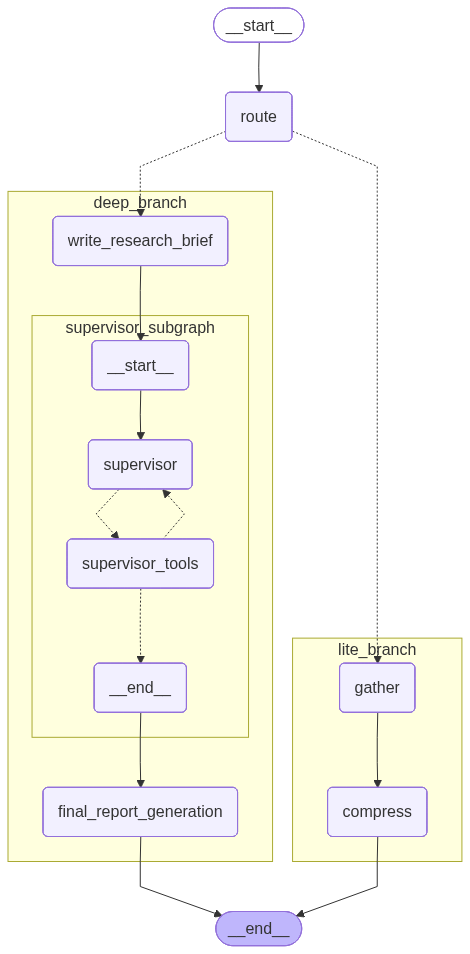

In [8]:
# Run the workflow
# from deep_research.utils import format_messages

from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research.router import router_builder

checkpointer = InMemorySaver()
full_agent = router_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=-1).draw_mermaid_png()))

In [4]:
import json 
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_upstage import ChatUpstage
llm = ChatUpstage(api_key=os.getenv("UPSTAGE_API_KEY"), model="solar-pro2")


# ✅ final_report 기반 한 줄 답 체인
one_line_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
당신은 한국어 최신성 QA 시스템의 마지막 단계입니다.

역할:
- 이전 단계에서 수행된 리서치 결과(final_report JSON)를 보고,
  Ko-FreshQA 리더보드 제출용 "최종 답변 한 줄"만 생성합니다.

출력 규칙:
1. 반드시 **질문에 대한 직접적인 정답만** 한국어로 출력하세요.
2. 불필요한 문장/접두어/추가 설명은 절대 쓰지 마세요.
   - 예: "제 지식은 ~까지입니다", "제가 아는 한", "추가로 말씀드리면" 금지.
3. 답변은 최대 1문장으로 짧게. (정말 필요할 때만 2문장)
4. 나이/날짜/개수/순번은 명확한 숫자로 답하세요.
   - 예) "23세입니다.", "2025년 8월 15일입니다.", "제31차 정상회의였습니다."
5. 정답에 필요한 핵심 정보만 포함하고, 나머지 부가 설명은 모두 제거합니다.
""".strip(),
        ),
        (
            "user",
            """
[질문]
{question}

[final_report JSON]
{final_report_json}

위 정보를 모두 고려해서,
Ko-FreshQA 리더보드 제출용 최종 답변 한 줄만 출력하세요.
""".strip(),
        ),
    ]
)

one_line_chain = one_line_prompt | llm | StrOutputParser()


In [5]:
import os
import uuid
import json
import asyncio
import pandas as pd
from dotenv import load_dotenv
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage
from deep_research.research_agent_full import deep_researcher_builder

load_dotenv()

checkpointer = InMemorySaver()
agent = deep_researcher_builder.compile(checkpointer=checkpointer)

# 🔹 ChatUpstage + one_line_chain은 이미 어딘가에 정의되어 있다고 가정
# from langchain_upstage import ChatUpstage
# from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.output_parsers import StrOutputParser
# llm = ChatUpstage(...)
# one_line_chain = one_line_prompt | llm | StrOutputParser()

async def run_agent_once(question: str) -> str:
    """
    1) 딥리서치 그래프 실행해서 final_report(JSON)를 얻고
    2) 그 JSON을 ChatUpstage 기반 LangChain 체인에 넣어 Ko-FreshQA용 한 줄 정답을 생성.
    """
    thread_cfg = {
        "configurable": {
            "thread_id": str(uuid.uuid4()),
            "recursion_limit": 10,
        }
    }

    # 1) LangGraph 딥리서치 실행 (⚠️ async → ainvoke)
    state = await agent.ainvoke(
        {"messages": [HumanMessage(content=question)]},
        config=thread_cfg,
    )

    final_report = state.get("final_report", {})
    try:
        final_report_json = json.dumps(final_report, ensure_ascii=False, indent=2)
    except TypeError:
        final_report_json = str(final_report)

    # 2) ChatUpstage + LangChain 체인으로 한 줄 정답 생성 (sync 체인이라 그냥 invoke)
    one_line_answer = one_line_chain.invoke(
        {
            "question": question,
            "final_report_json": final_report_json,
        }
    )

    # 안전하게 한 줄만 남기기
    if isinstance(one_line_answer, str):
        one_line_answer = one_line_answer.strip()
        if "\n" in one_line_answer:
            one_line_answer = one_line_answer.splitlines()[0].strip()
    else:
        one_line_answer = str(one_line_answer)

    return one_line_answer

async def process_row(idx: int, row, sem: asyncio.Semaphore):
    """세마포어로 동시 실행 개수 제한하면서 한 줄 처리."""
    question = row["question"]
    row_id = row["id"]

    async with sem:  # 🔒 여기 안에서만 LangGraph + LLM 호출
        print(f"[{idx}] id:{row_id}  question: {question}")
        ans = await run_agent_once(question)
        print(f"   → answer: {ans}")
        return idx, ans


# async def main():

#     input_path = "ko-freshqa_2025_dev.csv"
#     output_path = "ko-freshqa_2025_dev_with_model.csv"

#     df = pd.read_csv(
#         input_path,
#         encoding="utf-8",
#         header=0,
#         index_col=False,
#     )

#     df["model_response"] = ""  # 미리 컬럼 생성

#     # 🔑 동시에 몇 개까지 돌릴지 설정 (rate limit 때문에 1~3 정도 추천)
#     max_concurrency = 1
#     sem = asyncio.Semaphore(max_concurrency)

#     tasks = []
#     for idx, row in df.iterrows():
#         if idx > 8:
#             break
#         task = asyncio.create_task(process_row(idx, row, sem))
#         tasks.append(task)

#     # 완료되는 순서대로 결과 받아서 df에 채우기
#     for i, task in enumerate(asyncio.as_completed(tasks), start=1):
#         idx, ans = await task
#         df.at[idx, "model_response"] = ans
#         print(f"[{i}/{len(tasks)}] idx={idx} 저장 완료")

#     df.to_csv(output_path, index=False, encoding="utf-8")
#     print("저장 완료:", output_path)


# if __name__ == "__main__":
#     asyncio.run(main())   # 🔥 그대로 유지


In [ ]:
import asyncio
import pandas as pd
import os


async def main():
    input_path = "ko-freshqa_2025_test.csv"
    output_path = "ko-freshqa_2025_test_with_model.csv"

    # ✅ 1) 이미 output 파일이 있으면 그걸 우선 읽어서 이어서 작업
    if os.path.exists(output_path):
        print(f"[INFO] 기존 결과 파일 발견 → 이어서 실행: {output_path}")
        df = pd.read_csv(output_path, encoding="utf-8", header=0, index_col=False)
    else:
        print(f"[INFO] 결과 파일 없음 → 원본에서 시작: {input_path}")
        df = pd.read_csv(input_path, encoding="utf-8", header=0, index_col=False)

    # ✅ 2) model_response 컬럼 보장 + dtype을 문자열로 맞추기
    if "model_response" not in df.columns:
        df["model_response"] = ""
    else:
        # NaN 섞여 있어도 일단 문자열 취급
        df["model_response"] = df["model_response"].astype("string")

    max_concurrency = 1
    sem = asyncio.Semaphore(max_concurrency)

    tasks = []
    for idx, row in df.iterrows():
        val = row.get("model_response", "")
        # 이미 답이 채워져 있으면 스킵
        if isinstance(val, str) and val.strip():
            continue
        if pd.notna(val) and str(val).strip():
            # string dtype일 때도 방어적으로 한 번 더
            continue

        task = asyncio.create_task(process_row(idx, row, sem))
        tasks.append(task)

    total = len(tasks)
    print(f"총 작업 개수: {total}")

    for i, task in enumerate(asyncio.as_completed(tasks), start=1):
        try:
            idx, ans = await task
        except Exception as e:
            print(f"[ERROR] task 실패: {e}")
            continue

        df.at[idx, "model_response"] = ans
        print(f"[{i}/{total}] idx={idx} 저장 완료")

        # ✅ 매번 중간 저장
        df.to_csv(output_path, index=False, encoding="utf-8")
        print("  ↳ 부분 저장 완료:", os.path.abspath(output_path))

    print("최종 저장 완료:", os.path.abspath(output_path))


if __name__ == "__main__":
    asyncio.run(main())


In [9]:
from deep_research.utils import refine_kr_search_query

str1 = "가장 마지막으로 열린 APEC 정상회의가 몇 번째 정상회의였는지 알려줘."
refine_kr_search_query(str)

RefinedQuery(refined_query='APEC 정상회의 최근 횟수', needs_recency=False, site_hint=None)